In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import re
import pickle
import numpy as np
import string


file_path = 'datasets/Amazon0302.txt'


df = pd.read_csv(file_path, sep='\t', header=None, names=['Start_Node', 'End_Node'], nrows=1000) # Remove nrows before submitting to run on all data

G = nx.DiGraph()


for index, row in df.iterrows():
    G.add_edge(row['Start_Node'], row['End_Node'])


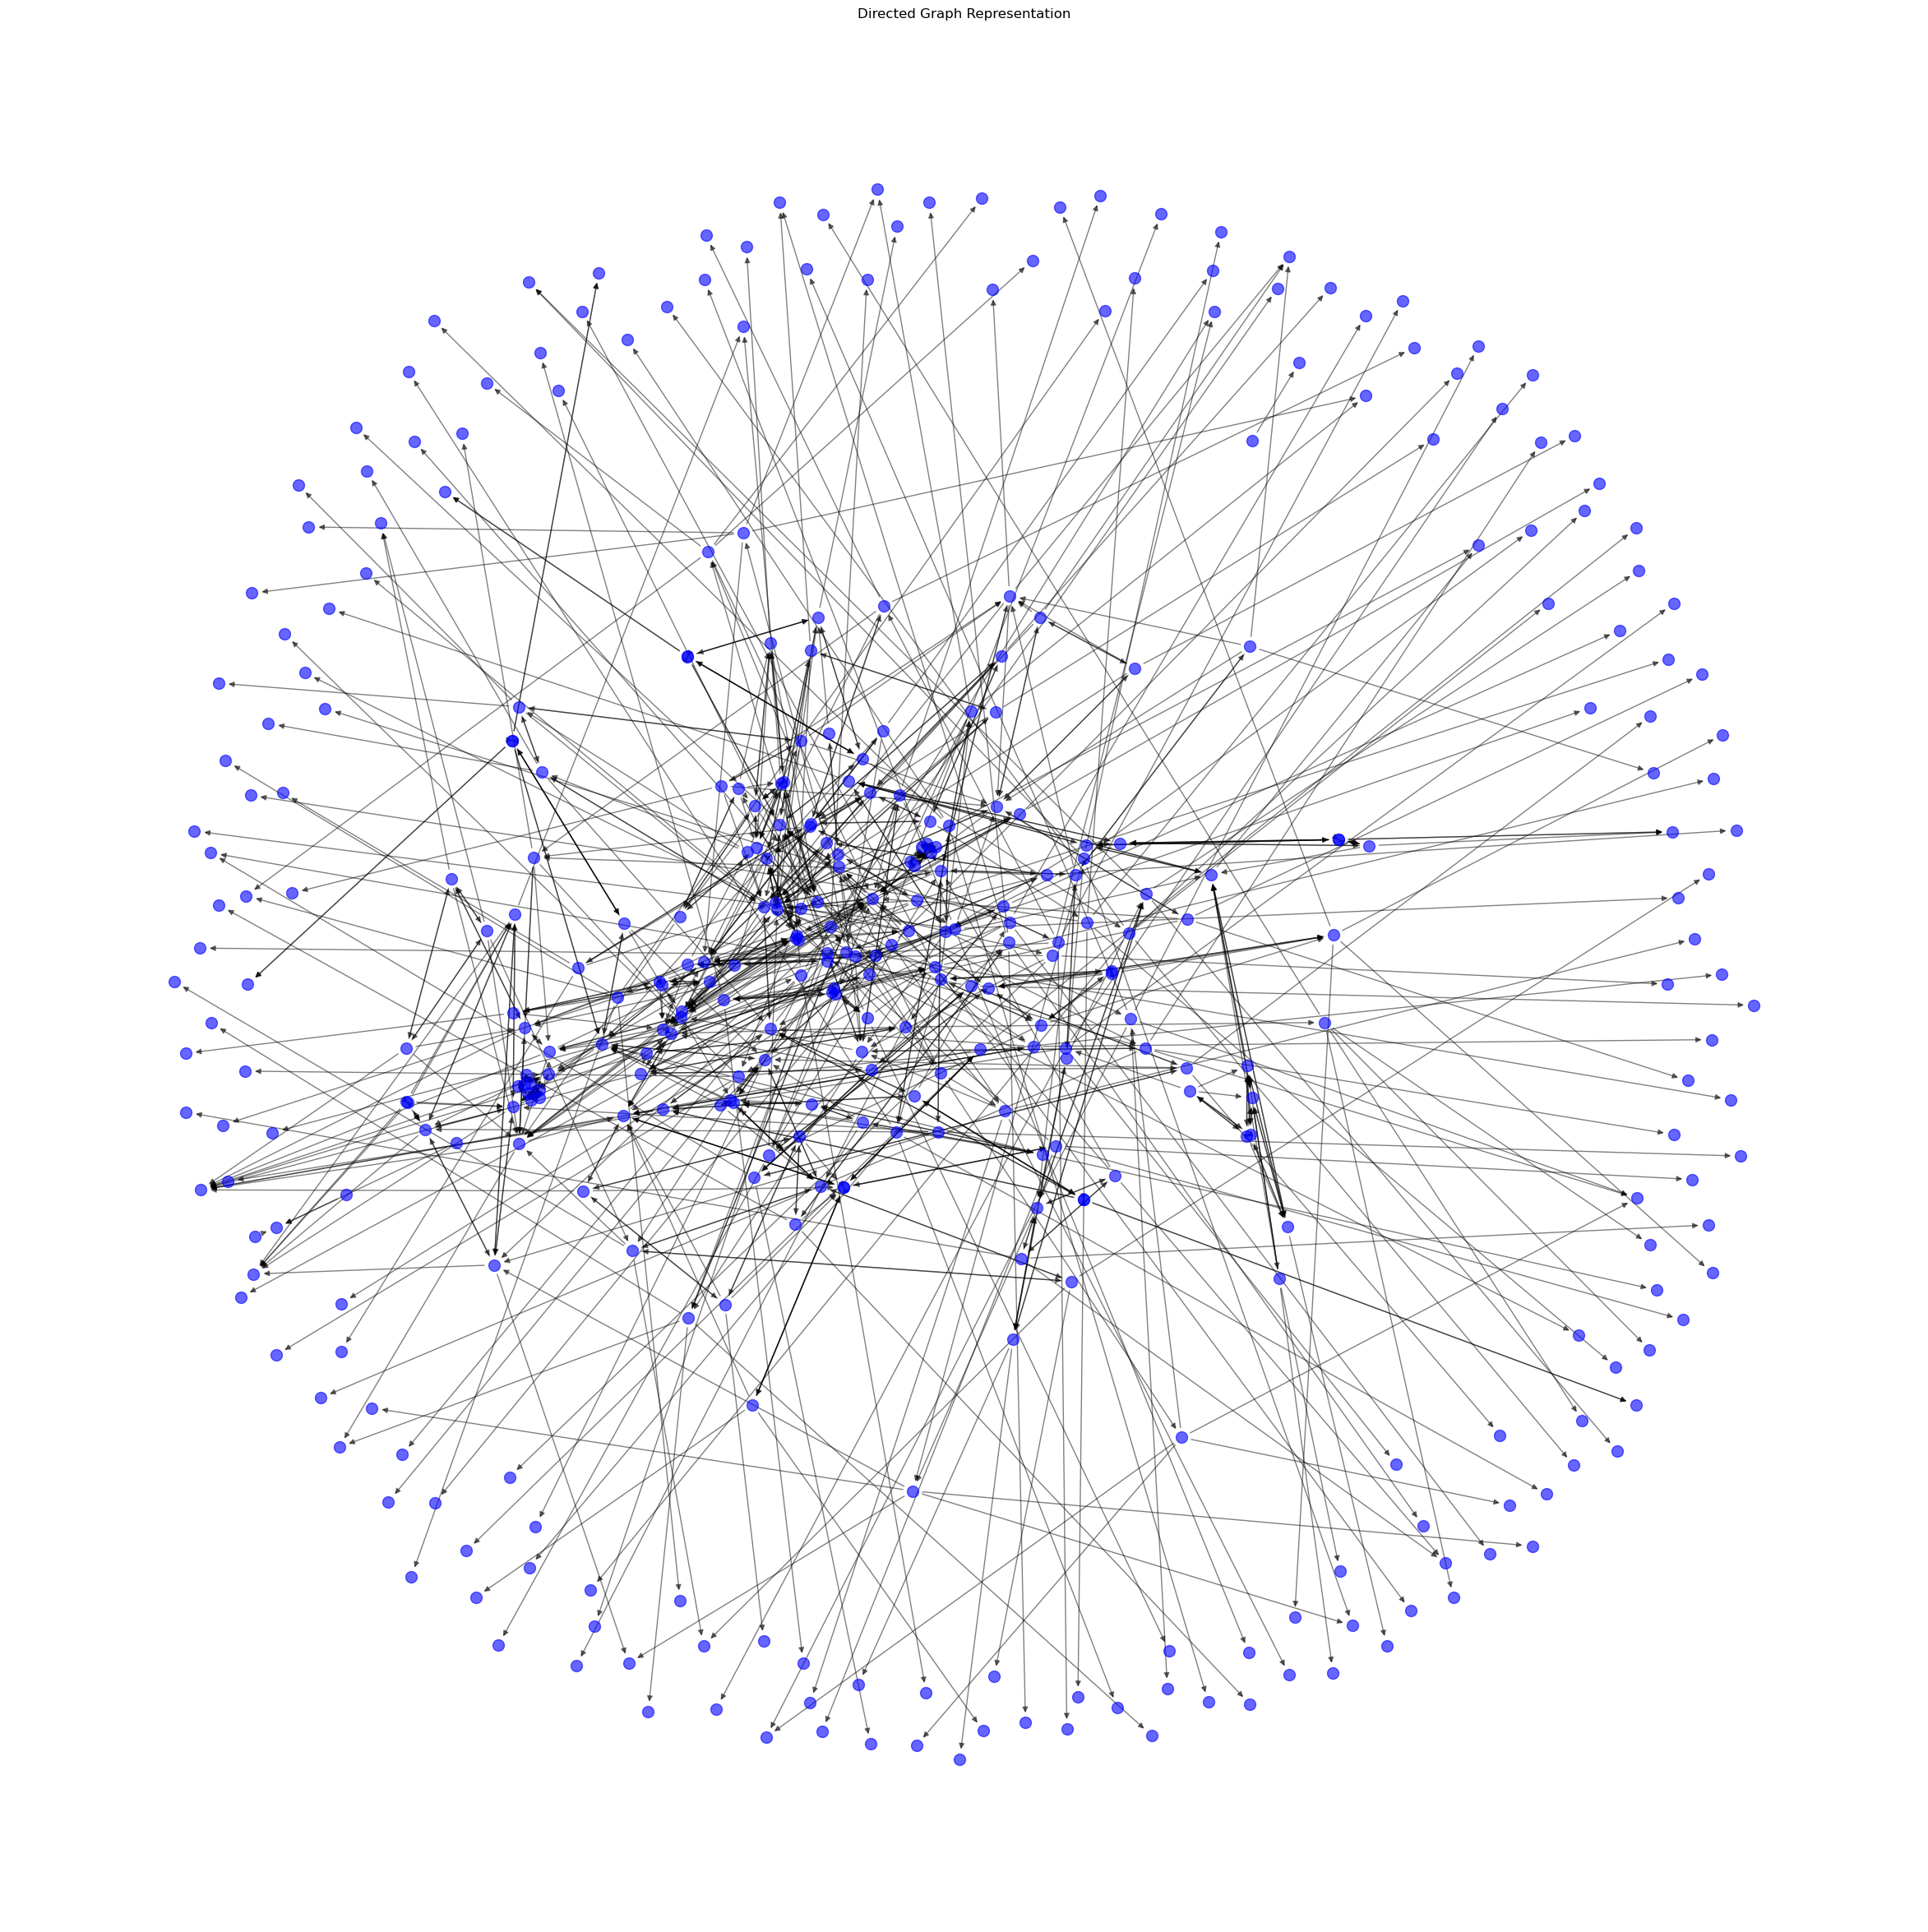

In [3]:
plt.figure(figsize=(30, 30))




pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrowstyle='-|>', arrowsize=10)


plt.title('Directed Graph Representation')
plt.axis('off')
plt.show()

In [5]:
# Calculation of dataset statistics from : https://snap.stanford.edu/data/amazon0302.html


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


G_undirected = G.to_undirected()

# Find all weakly connected components, sorted by size
wccs = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
sccs = sorted(nx.strongly_connected_components(G), key=len, reverse=True)

# Largest WCC
largest_wcc = wccs[0]
largest_scc = sccs[0]

# You can access the subgraph of the largest WCC like this
largest_wcc_subgraph = G.subgraph(largest_wcc)
largest_scc_subgraph = G.subgraph(largest_scc)

# Basic information about the largest WCC
print("Number of nodes in the largest WCC:", len(largest_wcc))
print("Number of edges in the largest WCC:", largest_wcc_subgraph.number_of_edges())
print("Number of nodes in the largest WCC:", len(largest_scc))
print("Number of edges in the largest WCC:", largest_scc_subgraph.number_of_edges())
print("Average Clustering Coeff:", nx.average_clustering(G))
print("Number of Triangles:", len(nx.triangles(G_undirected)))
print("Fraction of closed Triangles: ", nx.transitivity(G))
#print("Diameter (longest Shortest path):", nx.diameter(G_undirected))

Number of nodes: 394
Number of edges: 1000
Number of nodes in the largest WCC: 388
Number of edges in the largest WCC: 996
Number of nodes in the largest WCC: 126
Number of edges in the largest WCC: 482
Average Clustering Coeff: 0.21125839690772086
Number of Triangles: 394
Fraction of closed Triangles:  0.33870156014091596


In [6]:
def clean_string(input_string):
    pattern = r"\[.*"
    cleaned_string = re.sub(pattern, "", input_string)
    return cleaned_string.strip()  # strip() is used to remove any trailing newline or spaces

def parseCats(cats):
    parsed = []
    for i in cats[1:]:
        parsed.append( clean_string(i))
    return parsed
        
        

In [12]:
fhr = open('datasets/amazon-meta.txt', 'r', encoding='utf-8', errors='ignore')

productList = []
count = 0
for line in fhr:
    
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        Similar = line.strip().split()
        similarList=[]
        if(len(Similar)>2):
            for k in range(2,len(Similar),1):
                similarList.append(Similar[k])
    elif(line.startswith("categories")):
        ls = line.split()
        if(ls[1]!="0"):        
            Categories = ' '.join((fhr.readline()).lower() for i in range(1))
            Categories= Categories.split("|")
            #print(Catagories)
        else:
            Categories=""
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()

    # a product block ended
    # write out fields to list
    elif (line==""):
        try:
            MetaData = []
            MetaData.append(Id)
            MetaData.append(ASIN)
            MetaData.append(Group)
            MetaData.append(SalesRank)
            MetaData.append(similarList)
            MetaData.append(Categories)
            MetaData.append(TotalReviews)
            MetaData.append(AvgRating)
            productList.append(MetaData)
        except NameError:
            continue
fhr.close()

# # create books-specific list exclusively for books
# bookList = []
# count=0
# for product in productList:
#         if (product[2]=='Book'):
#             if(len(product[5])>3):
#                 Categories=product[5][3]
#                 Categories=Categories[0: Categories.index("["):]
#                 product[5]=Categories
#             bookList.append(product)
#             count+=1
#         if count == 200000:
#             break

df = pd.DataFrame(productList, columns = ['Id', 'ASIN',"Group",'SalesRank','Similar','Categories','TotalReviews','AvgRating',])
df


    


,Id,ASIN,Group,SalesRank,Similar,Categories,TotalReviews,AvgRating
0,216841,0631207368,Book,507054,"[0670031518, 0802847587, 0809139227, 026801897...","[ , books[283155], subjects[1000], nonfictio...",2,5
1,0,0771044445,Book,507054,"[0670031518, 0802847587, 0809139227, 026801897...","[ , books[283155], subjects[1000], nonfictio...",2,5
2,1,0827229534,Book,396585,"[0804215715, 156101074X, 0687023955, 068707423...","[ , books[283155], subjects[1000], religion ...",2,5
3,2,0738700797,Book,168596,"[0738700827, 1567184960, 1567182836, 073870052...","[ , books[283155], subjects[1000], religion ...",12,4.5
4,3,0486287785,Book,1270652,[],"[ , books[283155], subjects[1000], home & ga...",1,5
...,...,...,...,...,...,...,...,...
548548,548547,B000059TOC,DVD,0,"[630366704X, B0002ERXB8, B0001932ZU, B0001VTPU...","[ , [139452], dvd[130], genres[404276], dram...",1,5
548549,548548,B00006JBIX,DVD,0,"[B0002HOE6C, B0002I84JO, B00004WZQN, B00069CQ8...","[ , [139452], dvd[130], genres[404276], art ...",8,3
548550,548549,0879736836,Book,0,"[1931709920, 188187110X, 081890643X, 158051046...","[ , books[283155], subjects[1000], nonfictio...",1,4
548551,548550,B00008DDST,DVD,0,"[B00012FWNC, B0002UNQQI, B00069FKLO, B0000CNTH...","[ , [139452], dvd[130], genres[404276], musi...",3,5


In [13]:
df[ "Categories"][0]

['   ',
 'books[283155]',
 'subjects[1000]',
 'nonfiction[53]',
 'philosophy[11019]',
 'religious[11072]\n']